# Machine Learning Driven Identity Verification

In [12]:
#!pip3 install -r requirements.txt

In [13]:
#import dependancies
from PIL import Image
from PIL import ImageOps
import numpy as np
from keras.models import load_model
import tensorflow as tf
from model.dsnt import dsnt
from PIL import Image, ImageDraw
import cv2
import os
import requests
import json
import io
from matplotlib import pyplot as plt

In [14]:
#load tensorflow graph
def _load_graph(frozen_graph_filename):
    with tf.gfile.GFile(frozen_graph_filename, "rb") as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")
    return graph

In [15]:
#specify frozen model location and map of keypoints
freeze_file_name = "model/frozen_model.pb"
graph = _load_graph(freeze_file_name)
sess = tf.Session(graph=graph)
inputs = graph.get_tensor_by_name('input:0')
activation_map = graph.get_tensor_by_name("heats_map_regression/pred_keypoints/BiasAdd:0")

hm1, kp1, = dsnt(activation_map[...,0])
hm2, kp2, = dsnt(activation_map[...,1])
hm3, kp3, = dsnt(activation_map[...,2])
hm4, kp4, = dsnt(activation_map[...,3])

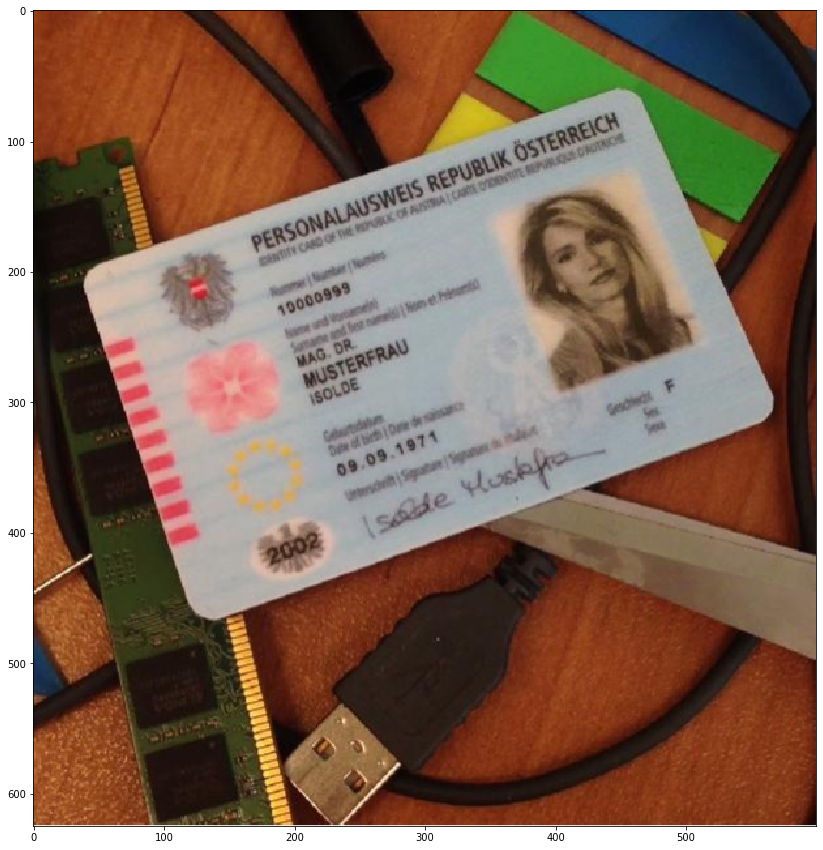

In [24]:
#read sample original image , convert to RGB, display
img = cv2.imread("in/id-card.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(img)

In [25]:
#the images were trained in TensorFlow in 600x800 dimension. We need the ratio dimensions to deskew in later step
rw = img.shape[1] / 600
rh = img.shape[0] /800
print (rw,rh)

1.0 0.78125


In [26]:
#open image again , this time to numpy array and resize to 600 x 800 to match training parameters.
img_nd = np.array(Image.open('in/id-card.jpg').resize((600, 800)))

In [27]:
#map image to trained keypoints
hm1_nd,hm2_nd,hm3_nd,hm4_nd,kp1_nd,kp2_nd,kp3_nd,kp4_nd = sess.run([hm1,hm2,hm3,hm4,kp1,kp2,kp3,kp4], feed_dict={inputs: np.expand_dims(img_nd, 0)})

keypoints_nd = np.array([kp1_nd[0],kp2_nd[0],kp3_nd[0],kp4_nd[0]])
keypoints_nd = ((keypoints_nd+1)/2 * np.array([600, 800])).astype('int')

x1 = (keypoints_nd[0,0] + keypoints_nd[2,0])/2.0
y1 = (keypoints_nd[0,1] + keypoints_nd[1,1])/2.0
x2 = (keypoints_nd[1,0] + keypoints_nd[3,0])/2.0
y2 = (keypoints_nd[2,1] + keypoints_nd[3,1])/2.0

new_kp1, new_kp2, new_kp3, new_kp4 = np.array([x1,y1]),np.array([x2,y1]),np.array([x1,y2]),np.array([x2,y2])

src_pts = keypoints_nd.astype('float32')
dst_pts = np.array([new_kp1, new_kp2, new_kp3, new_kp4]).astype('float32')


In [28]:
# get the transfrom matrix
img_nd_bgr = cv2.cvtColor(img_nd, cv2.COLOR_RGB2BGR)
H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
resize_factor = img_nd_bgr.shape[1] * 1.0 / (x2-x1)
height, width = img_nd_bgr.shape[:2]
new_height, new_width = int(height*resize_factor), int(width*resize_factor)
transfomed_image = cv2.warpPerspective(img_nd_bgr, H, (new_width, new_height))#tuple(reversed(img_nd_bgr.shape[:2]))

cropped_image = transfomed_image[int(y1):int(y2), int(x1):int(x2), :]



In [29]:
# draw keypoints for smart crop
cv2.line(img_nd_bgr, tuple(keypoints_nd[0]), tuple(keypoints_nd[1]), [0,255,0], 3)
cv2.line(img_nd_bgr, tuple(keypoints_nd[1]), tuple(keypoints_nd[3]), [0,255,0], 3)
cv2.line(img_nd_bgr, tuple(keypoints_nd[3]), tuple(keypoints_nd[2]), [0,255,0], 3)
cv2.line(img_nd_bgr, tuple(keypoints_nd[2]), tuple(keypoints_nd[0]), [0,255,0], 3)

hm = hm1_nd[0]+hm2_nd[0]+hm3_nd[0]+hm4_nd[0]
hm *= 255
hm = hm.astype('uint8')
color_heatmap = cv2.applyColorMap(hm, cv2.COLORMAP_JET)
color_heatmap = cv2.resize(color_heatmap, (600, 800))


In [32]:
#get smart cropped image dimensions and revert resize factor applied previously
cv2.imwrite('tmp/jupyter-cropped-warped.jpg',cropped_image)
print (cropped_image.shape)
dim = (int(cropped_image.shape[1] * rw), int(cropped_image.shape[0] * rh))
final = cv2.resize(cropped_image, dim, interpolation = cv2.INTER_AREA)
cv2.imwrite('tmp/jupyter-final.jpg',final)



(334, 437, 3)


True

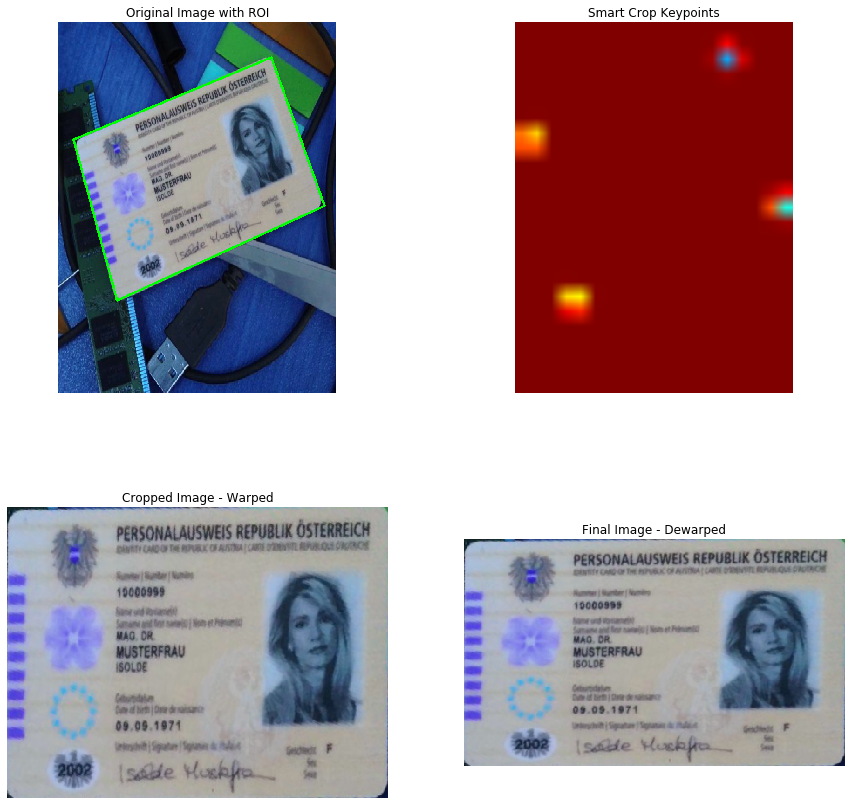

In [31]:
plt.figure(figsize=(15, 15))

plt.subplot(221)
plt.imshow(img_nd_bgr)
plt.title('Original Image with ROI')
plt.axis('off')

plt.subplot(222)
plt.imshow(color_heatmap)
plt.title('Smart Crop Keypoints')
plt.axis('off')

plt.subplot(223)
plt.imshow(cropped_image)
plt.title('Cropped Image - Warped')
plt.axis('off')

plt.subplot(224)
plt.imshow(final)
plt.title('Final Image - Dewarped')
plt.axis('off')


plt.savefig('tmp/jupyter-results.jpg')